In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
df.shape

(131045, 10)

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def factor(df, window=94):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    return factor_series.fillna(0)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.027766
   Rank_IC (Spearman): 0.009608
📊 信息比率:
   IR: 0.458249
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


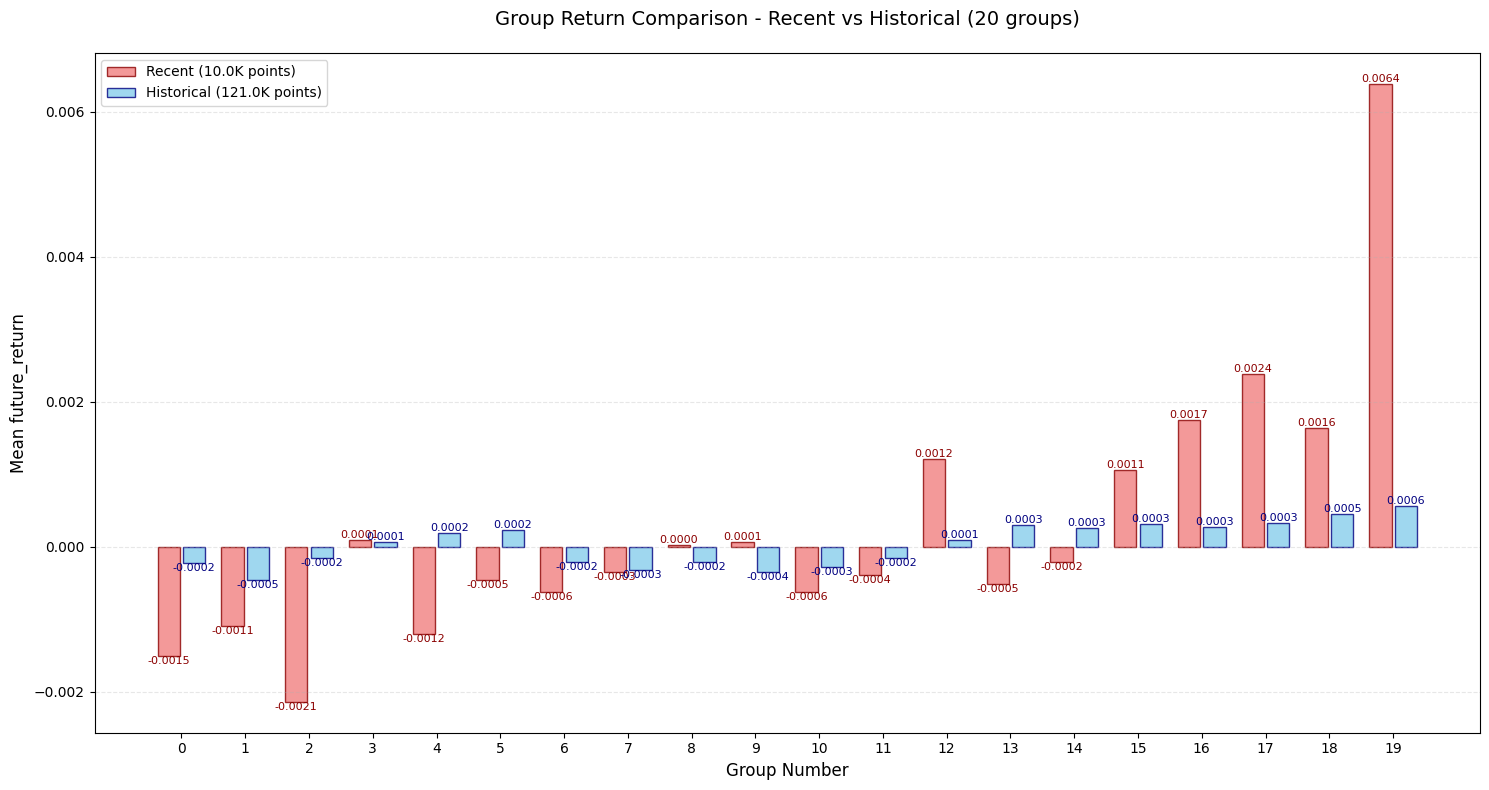

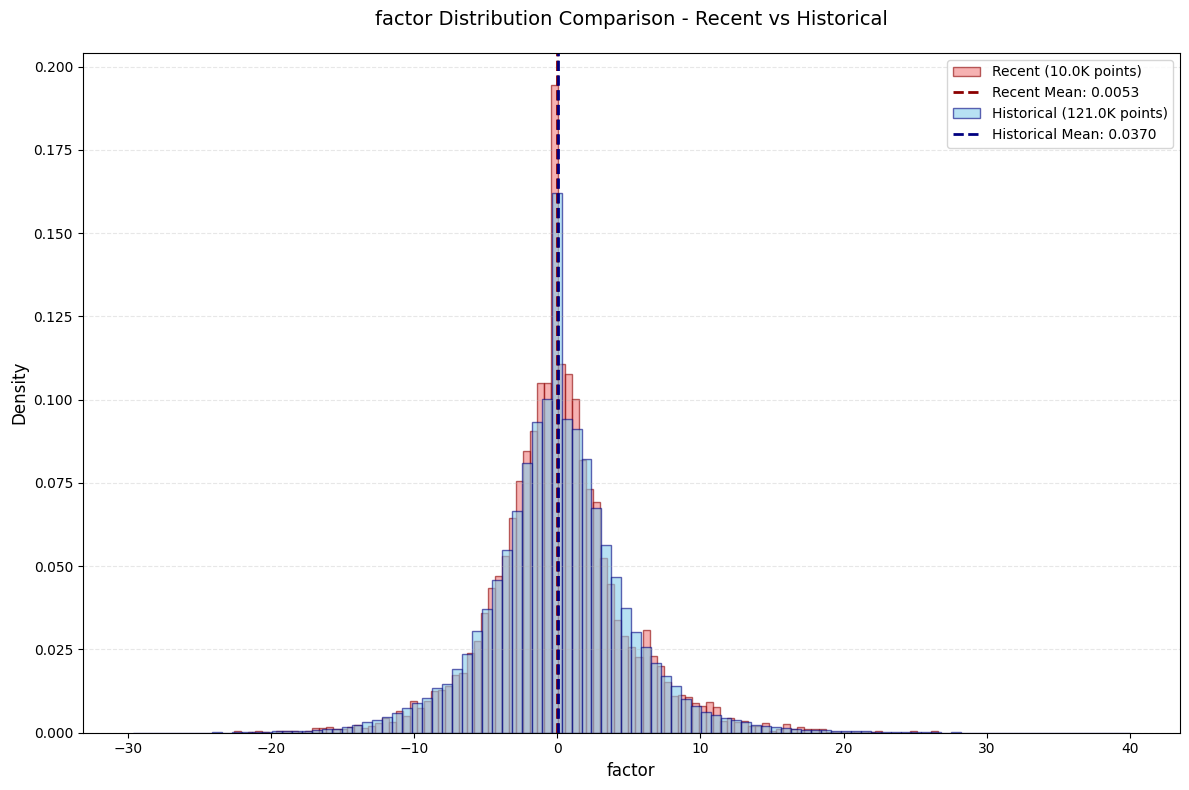

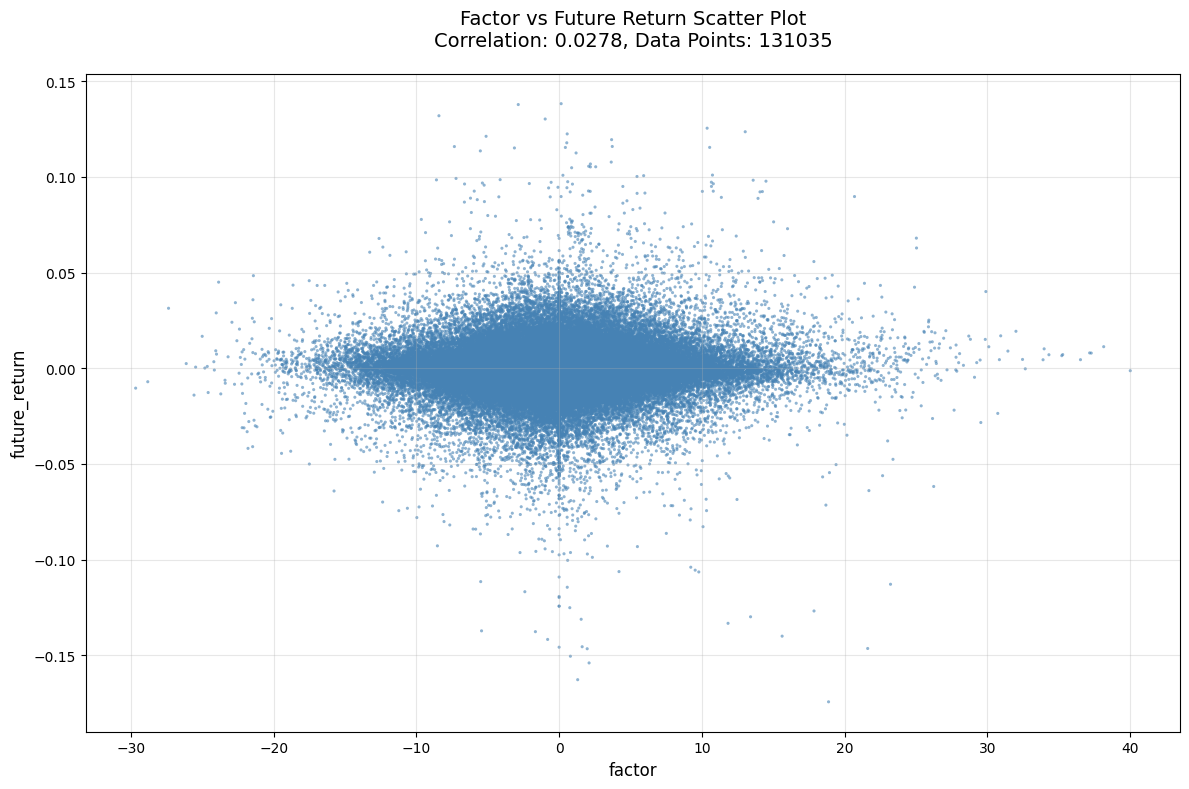

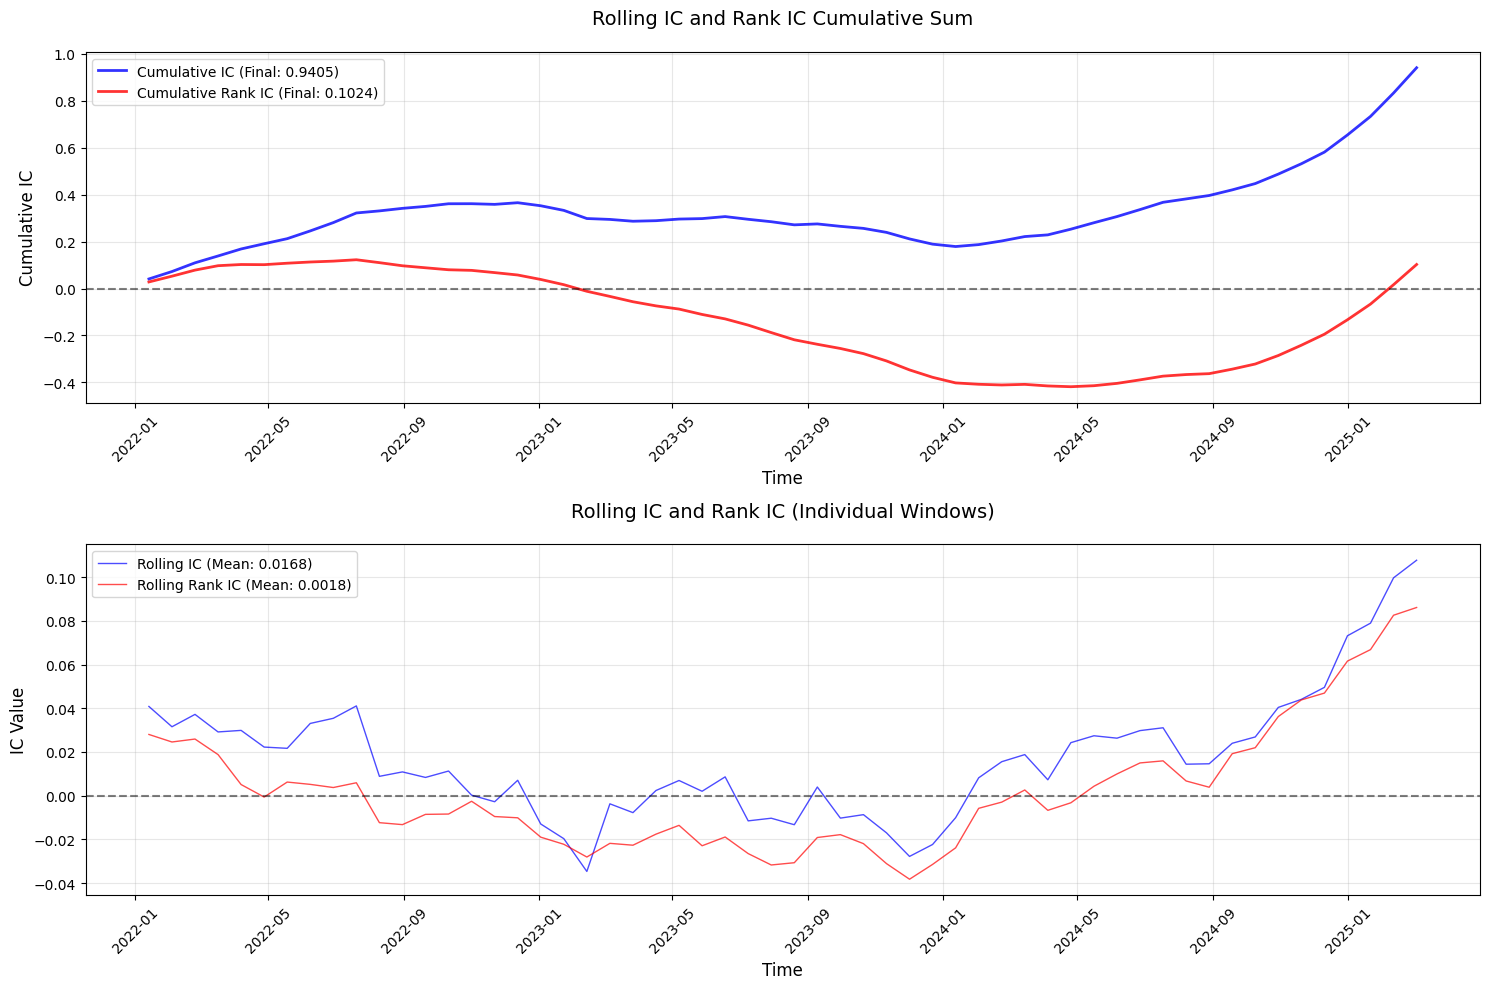

✅ 已显示 4 个图片
----------------------------------------


In [6]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.01690796479513809,
 0.017082174178146198,
 0.0015363590771937847,
 0.0023839418253158388,
 -0.010124699828869344,
 0.02355724951420949,
 0.0016114718532066448,
 0.009478070331710262,
 0.0028196744056216494,
 0.04323663360510031]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.0277662954904948, 'Rank_IC': 0.00960788248911194}, 'information_ratio': {'IR': 0.45824880084263897, 'group_correlations': [-0.01690796479513809, 0.017082174178146198, 0.0015363590771937847, 0.0023839418253158388, -0.010124699828869344, 0.02355724951420949, 0.0016114718532066448, 0.009478070331710262, 0.0028196744056216494, 0.04323663360510031], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -29.6643  -7.8114  -10.8188      -0.0003      0.0134   6552
1      -7.8113  -5.4966   -6.5002      -0.0005      0.0127   6552
2      -5.4966  -4.2037   -4.8063      -0.0003      0.0123   6552
3      -4.2037  -3.2444   -3.7009      -0.0000      0.0112   6551
4      -3.2443  -2.4907   -2.8543       0.0001      0.0113   6552
5      -2.4904  -1.8699   -2.1712       0.0001      0.0114   6552
6      -1.8697  -1.3204   -1.5876      -

In [ ]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+---------------------+
| 指标                | 值                  |
+=====================+=====================+
| 信息系数(IC)        | 0.0277662954904948  |
+---------------------+---------------------+
| 秩相关系数(Rank IC) | 0.00960788248911194 |
+---------------------+---------------------+
| 信息比率(IR)        | 0.45824880084263897 |
+---------------------+---------------------+
| 分组数量            | 10                  |
+---------------------+---------------------+
| 数据点数            | 131,035             |
+---------------------+---------------------+
| 异常值(>3σ)         | 1.31%               |
+---------------------+---------------------+
| 异常值(>5σ)         | 0.08%               |
+---------------------+---------------------+

                                     分组分析结果                                     
+--------+----------+----------+----------+------------+--------------+----------+
| 